In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : [],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_e_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2059099, 937)
(2059099, 1)
validation
(214378, 937)
(214378, 1)
test
(273100, 937)
(273100, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 937)]             0         


 dense (Dense)               (None, 1024)              960512    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1649665 (6.29 MB)


Trainable params: 1649665 (6.29 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/206 [..............................] - ETA: 4:09 - loss: 0.0672 - STD: 2.6094e-04 - MAE: 0.2279

  4/206 [..............................] - ETA: 3s - loss: 0.0639 - STD: 9.2822e-04 - MAE: 0.2061  

  8/206 [>.............................] - ETA: 3s - loss: 0.0594 - STD: 0.0029 - MAE: 0.2062    

 11/206 [>.............................] - ETA: 3s - loss: 0.0568 - STD: 0.0044 - MAE: 0.2026

 14/206 [=>............................] - ETA: 3s - loss: 0.0554 - STD: 0.0062 - MAE: 0.1989

 17/206 [=>............................] - ETA: 3s - loss: 0.0533 - STD: 0.0094 - MAE: 0.1957

 20/206 [=>............................] - ETA: 3s - loss: 0.0513 - STD: 0.0147 - MAE: 0.1925

 23/206 [==>...........................] - ETA: 3s - loss: 0.0484 - STD: 0.0222 - MAE: 0.1859

 26/206 [==>...........................] - ETA: 3s - loss: 0.0451 - STD: 0.0341 - MAE: 0.1773

 29/206 [===>..........................] - ETA: 3s - loss: 0.0420 - STD: 0.0495 - MAE: 0.1690

 32/206 [===>..........................] - ETA: 3s - loss: 0.0394 - STD: 0.0638 - MAE: 0.1621

 35/206 [====>.........................] - ETA: 3s - loss: 0.0372 - STD: 0.0788 - MAE: 0.1565

 38/206 [====>.........................] - ETA: 3s - loss: 0.0354 - STD: 0.0907 - MAE: 0.1518

 41/206 [====>.........................] - ETA: 3s - loss: 0.0338 - STD: 0.1012 - MAE: 0.1473

 44/206 [=====>........................] - ETA: 3s - loss: 0.0323 - STD: 0.1085 - MAE: 0.1431

 47/206 [=====>........................] - ETA: 3s - loss: 0.0309 - STD: 0.1140 - MAE: 0.1391

 50/206 [======>.......................] - ETA: 3s - loss: 0.0297 - STD: 0.1177 - MAE: 0.1358

 53/206 [======>.......................] - ETA: 3s - loss: 0.0287 - STD: 0.1216 - MAE: 0.1326

 56/206 [=======>......................] - ETA: 2s - loss: 0.0277 - STD: 0.1254 - MAE: 0.1297

 59/206 [=======>......................] - ETA: 2s - loss: 0.0268 - STD: 0.1297 - MAE: 0.1271

 62/206 [========>.....................] - ETA: 2s - loss: 0.0259 - STD: 0.1335 - MAE: 0.1248

 65/206 [========>.....................] - ETA: 2s - loss: 0.0252 - STD: 0.1372 - MAE: 0.1225

 68/206 [========>.....................] - ETA: 2s - loss: 0.0244 - STD: 0.1400 - MAE: 0.1204

 71/206 [=========>....................] - ETA: 2s - loss: 0.0237 - STD: 0.1425 - MAE: 0.1183

 74/206 [=========>....................] - ETA: 2s - loss: 0.0231 - STD: 0.1447 - MAE: 0.1164

 77/206 [==========>...................] - ETA: 2s - loss: 0.0225 - STD: 0.1470 - MAE: 0.1146

 80/206 [==========>...................] - ETA: 2s - loss: 0.0219 - STD: 0.1493 - MAE: 0.1128

 83/206 [===========>..................] - ETA: 2s - loss: 0.0214 - STD: 0.1516 - MAE: 0.1112

 85/206 [===========>..................] - ETA: 3s - loss: 0.0211 - STD: 0.1529 - MAE: 0.1101

 88/206 [===========>..................] - ETA: 3s - loss: 0.0206 - STD: 0.1547 - MAE: 0.1085

 92/206 [============>.................] - ETA: 2s - loss: 0.0200 - STD: 0.1570 - MAE: 0.1065

 95/206 [============>.................] - ETA: 2s - loss: 0.0195 - STD: 0.1587 - MAE: 0.1051

 99/206 [=============>................] - ETA: 2s - loss: 0.0190 - STD: 0.1609 - MAE: 0.1032

102/206 [=============>................] - ETA: 2s - loss: 0.0186 - STD: 0.1624 - MAE: 0.1019

105/206 [==============>...............] - ETA: 2s - loss: 0.0182 - STD: 0.1638 - MAE: 0.1007

108/206 [==============>...............] - ETA: 2s - loss: 0.0178 - STD: 0.1652 - MAE: 0.0995

111/206 [===============>..............] - ETA: 2s - loss: 0.0175 - STD: 0.1665 - MAE: 0.0984

114/206 [===============>..............] - ETA: 2s - loss: 0.0172 - STD: 0.1679 - MAE: 0.0973

117/206 [================>.............] - ETA: 2s - loss: 0.0169 - STD: 0.1691 - MAE: 0.0963

120/206 [================>.............] - ETA: 2s - loss: 0.0166 - STD: 0.1703 - MAE: 0.0952

123/206 [================>.............] - ETA: 2s - loss: 0.0163 - STD: 0.1714 - MAE: 0.0943

126/206 [=================>............] - ETA: 1s - loss: 0.0160 - STD: 0.1725 - MAE: 0.0933

129/206 [=================>............] - ETA: 1s - loss: 0.0158 - STD: 0.1735 - MAE: 0.0925

132/206 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 0.1744 - MAE: 0.0916

135/206 [==================>...........] - ETA: 1s - loss: 0.0153 - STD: 0.1754 - MAE: 0.0908

138/206 [===================>..........] - ETA: 1s - loss: 0.0151 - STD: 0.1763 - MAE: 0.0900

141/206 [===================>..........] - ETA: 1s - loss: 0.0148 - STD: 0.1772 - MAE: 0.0892

144/206 [===================>..........] - ETA: 1s - loss: 0.0146 - STD: 0.1780 - MAE: 0.0885

147/206 [====================>.........] - ETA: 1s - loss: 0.0144 - STD: 0.1788 - MAE: 0.0877

150/206 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.1796 - MAE: 0.0870

153/206 [=====================>........] - ETA: 1s - loss: 0.0141 - STD: 0.1804 - MAE: 0.0864

156/206 [=====================>........] - ETA: 1s - loss: 0.0139 - STD: 0.1811 - MAE: 0.0858

159/206 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 0.1818 - MAE: 0.0851

162/206 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 0.1824 - MAE: 0.0846

165/206 [=======================>......] - ETA: 0s - loss: 0.0134 - STD: 0.1831 - MAE: 0.0840

168/206 [=======================>......] - ETA: 0s - loss: 0.0132 - STD: 0.1837 - MAE: 0.0834

171/206 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 0.1842 - MAE: 0.0828

174/206 [========================>.....] - ETA: 0s - loss: 0.0129 - STD: 0.1848 - MAE: 0.0823

177/206 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 0.1854 - MAE: 0.0817

180/206 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.1859 - MAE: 0.0812

183/206 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.1864 - MAE: 0.0807

186/206 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.1870 - MAE: 0.0803

189/206 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 0.1875 - MAE: 0.0798

192/206 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.1879 - MAE: 0.0794

195/206 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.1884 - MAE: 0.0789

198/206 [===========================>..] - ETA: 0s - loss: 0.0119 - STD: 0.1888 - MAE: 0.0785

201/206 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.1893 - MAE: 0.0780

204/206 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.1897 - MAE: 0.0776

206/206 [==============================] - 7s 27ms/step - loss: 0.0116 - STD: 0.1899 - MAE: 0.0774 - val_loss: 0.0036 - val_STD: 0.0744 - val_MAE: 0.0495


Epoch 2/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0047 - STD: 0.2111 - MAE: 0.0547

  4/206 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.2170 - MAE: 0.0513 

  7/206 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.2175 - MAE: 0.0510

 10/206 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.2174 - MAE: 0.0505

 13/206 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.2174 - MAE: 0.0502

 16/206 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.2173 - MAE: 0.0499

 19/206 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.2174 - MAE: 0.0497

 22/206 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.2174 - MAE: 0.0496

 25/206 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.2177 - MAE: 0.0495

 28/206 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0494

 31/206 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 34/206 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.2178 - MAE: 0.0492

 37/206 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.2180 - MAE: 0.0492

 40/206 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 43/206 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0491

 46/206 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.2180 - MAE: 0.0491

 49/206 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 52/206 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 55/206 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 58/206 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.2179 - MAE: 0.0492

 61/206 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.2178 - MAE: 0.0492

 64/206 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.2177 - MAE: 0.0492

 67/206 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.2177 - MAE: 0.0492

 70/206 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.2177 - MAE: 0.0491

 73/206 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.2178 - MAE: 0.0491

 76/206 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.2178 - MAE: 0.0490

 79/206 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.2178 - MAE: 0.0490

 82/206 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.2178 - MAE: 0.0490

 85/206 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.2179 - MAE: 0.0490

 88/206 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.2179 - MAE: 0.0490

 91/206 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.2178 - MAE: 0.0489

 94/206 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.2179 - MAE: 0.0488

 97/206 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.2179 - MAE: 0.0488

100/206 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0487

103/206 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0486

106/206 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0486

109/206 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0486

112/206 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.2180 - MAE: 0.0485

115/206 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0485

118/206 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0484

121/206 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0484

124/206 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0483

127/206 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0483

130/206 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0482

133/206 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0481

136/206 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.2181 - MAE: 0.0481

139/206 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0480

142/206 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0480

145/206 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0479

148/206 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0479

151/206 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.2182 - MAE: 0.0479

154/206 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.2183 - MAE: 0.0479

157/206 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.2183 - MAE: 0.0478

160/206 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0478

163/206 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0477

166/206 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0477

169/206 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0476

172/206 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0476

175/206 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0476

178/206 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.2183 - MAE: 0.0476

181/206 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0475

184/206 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0475

187/206 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0475

190/206 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0474

193/206 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2184 - MAE: 0.0474

196/206 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2185 - MAE: 0.0474

199/206 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2185 - MAE: 0.0473

202/206 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2185 - MAE: 0.0473

205/206 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2185 - MAE: 0.0473

206/206 [==============================] - 5s 22ms/step - loss: 0.0038 - STD: 0.2185 - MAE: 0.0472 - val_loss: 0.0050 - val_STD: 0.0749 - val_MAE: 0.0527


Epoch 3/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0036 - STD: 0.2220 - MAE: 0.0454

  4/206 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.2199 - MAE: 0.0460 

  7/206 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.2193 - MAE: 0.0452

 10/206 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.2193 - MAE: 0.0450

 13/206 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.2193 - MAE: 0.0449

 16/206 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.2192 - MAE: 0.0449

 20/206 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.2196 - MAE: 0.0452

 23/206 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.2195 - MAE: 0.0451

 26/206 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.2193 - MAE: 0.0449

 29/206 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0448

 32/206 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0447

 35/206 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0446

 38/206 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0446

 41/206 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0445

 44/206 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0445

 47/206 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0448

 50/206 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0448

 53/206 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0447

 56/206 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0448

 59/206 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0448

 62/206 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0448

 65/206 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0448

 68/206 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0448

 71/206 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.2193 - MAE: 0.0448

 75/206 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0447

 78/206 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0446

 81/206 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0445

 84/206 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0445

 87/206 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0444

 91/206 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0446

 94/206 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0446

 97/206 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.2194 - MAE: 0.0447

101/206 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0446

104/206 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0446

107/206 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0446

111/206 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0445

114/206 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0445

118/206 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.2195 - MAE: 0.0444

122/206 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0444

125/206 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0443

128/206 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0443

132/206 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.2196 - MAE: 0.0443

136/206 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

140/206 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

144/206 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

148/206 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

152/206 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

155/206 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

158/206 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

162/206 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.2197 - MAE: 0.0443

166/206 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.2197 - MAE: 0.0442

169/206 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.2197 - MAE: 0.0442

173/206 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.2197 - MAE: 0.0442

176/206 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.2197 - MAE: 0.0441

180/206 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

184/206 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

187/206 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

190/206 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

193/206 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

197/206 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

201/206 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0441

205/206 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2198 - MAE: 0.0440

206/206 [==============================] - 4s 20ms/step - loss: 0.0033 - STD: 0.2198 - MAE: 0.0440 - val_loss: 0.0039 - val_STD: 0.0748 - val_MAE: 0.0471


Epoch 4/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0030 - STD: 0.2216 - MAE: 0.0421

  4/206 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.2217 - MAE: 0.0419 

  7/206 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.2208 - MAE: 0.0425

 10/206 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.2211 - MAE: 0.0424

 13/206 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0427

 16/206 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0426

 19/206 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0427

 22/206 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0426

 25/206 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0424

 28/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0425

 31/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0424

 34/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0423

 37/206 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0423

 40/206 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.2202 - MAE: 0.0423

 43/206 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0425

 46/206 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0426

 49/206 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0427

 52/206 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.2203 - MAE: 0.0428

 55/206 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.2203 - MAE: 0.0428

 58/206 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.2202 - MAE: 0.0428

 61/206 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0427

 64/206 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0427

 67/206 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0426

 70/206 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0426

 73/206 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0425

 76/206 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.2203 - MAE: 0.0426

 79/206 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

 82/206 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 85/206 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 88/206 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 91/206 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 94/206 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 97/206 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

100/206 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

103/206 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

106/206 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

109/206 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

112/206 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

115/206 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0424

118/206 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0424

121/206 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

124/206 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0425

127/206 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

130/206 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

133/206 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

136/206 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

139/206 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

142/206 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

145/206 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

148/206 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0423

151/206 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

154/206 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0424

157/206 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0424

160/206 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0424

163/206 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0423

166/206 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

169/206 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

172/206 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0424

175/206 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0423

178/206 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0423

181/206 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0423

184/206 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0423

187/206 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0422

190/206 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0422

193/206 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0422

196/206 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0422

199/206 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0422

202/206 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0421

205/206 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0421

206/206 [==============================] - 5s 22ms/step - loss: 0.0031 - STD: 0.2207 - MAE: 0.0421 - val_loss: 0.0033 - val_STD: 0.0736 - val_MAE: 0.0447


Epoch 5/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.2192 - MAE: 0.0415

  4/206 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.2199 - MAE: 0.0434

  7/206 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.2196 - MAE: 0.0437

 10/206 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.2201 - MAE: 0.0430

 13/206 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.2203 - MAE: 0.0431

 16/206 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.2201 - MAE: 0.0427

 19/206 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.2204 - MAE: 0.0426

 22/206 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0424

 25/206 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0426

 28/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0426

 31/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0425

 34/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0425

 37/206 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0423

 40/206 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.2205 - MAE: 0.0423

 44/206 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0422

 47/206 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0421

 50/206 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0420

 53/206 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.2206 - MAE: 0.0420

 56/206 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0419

 59/206 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.2207 - MAE: 0.0418

 62/206 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.2207 - MAE: 0.0418

 66/206 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 69/206 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0418

 72/206 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 75/206 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 78/206 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 81/206 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 84/206 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

 87/206 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.2207 - MAE: 0.0416

 90/206 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0416

 93/206 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0416

 96/206 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0415

 99/206 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0416

103/206 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0416

107/206 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0417

110/206 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0417

113/206 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

116/206 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.2208 - MAE: 0.0417

119/206 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0417

122/206 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0416

126/206 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0416

129/206 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0416

132/206 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0415

135/206 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0415

138/206 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0414

141/206 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0414

144/206 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0414

147/206 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.2209 - MAE: 0.0413

150/206 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

153/206 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

156/206 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

159/206 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

162/206 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

165/206 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412

168/206 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412

171/206 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412

174/206 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0412

177/206 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0411

180/206 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0411

183/206 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0411

186/206 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0410

189/206 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0411

192/206 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.2211 - MAE: 0.0411

195/206 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

198/206 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412

201/206 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0413

205/206 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412

206/206 [==============================] - 4s 20ms/step - loss: 0.0030 - STD: 0.2210 - MAE: 0.0412 - val_loss: 0.0041 - val_STD: 0.0744 - val_MAE: 0.0480


Epoch 6/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0028 - STD: 0.2226 - MAE: 0.0395

  4/206 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.2212 - MAE: 0.0411 

  7/206 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.2207 - MAE: 0.0405

 10/206 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.2209 - MAE: 0.0402

 13/206 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.2209 - MAE: 0.0401

 16/206 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0401

 19/206 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.2211 - MAE: 0.0401

 22/206 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.2213 - MAE: 0.0400

 25/206 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.2212 - MAE: 0.0399

 28/206 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0399

 31/206 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.2213 - MAE: 0.0398

 34/206 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

 37/206 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0398

 40/206 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0398

 43/206 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0398

 46/206 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

 49/206 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

 52/206 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

 55/206 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

 58/206 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0397

 62/206 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0397

 65/206 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0397

 68/206 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0399

 71/206 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.2216 - MAE: 0.0401

 74/206 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 77/206 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

 81/206 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 84/206 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 87/206 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 90/206 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

 93/206 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

 96/206 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 99/206 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0402

102/206 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0403

105/206 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0403

108/206 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0403

111/206 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0403

114/206 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0402

117/206 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0402

120/206 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0402

123/206 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0401

126/206 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0401

130/206 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

133/206 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

136/206 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

140/206 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0401

144/206 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0400

148/206 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0400

151/206 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0400

154/206 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0400

157/206 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0400

160/206 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0400

163/206 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0400

166/206 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.2214 - MAE: 0.0400

169/206 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0400

172/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0400

175/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

178/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

181/206 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

184/206 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

188/206 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

191/206 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

194/206 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

198/206 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

202/206 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

206/206 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398

206/206 [==============================] - 4s 20ms/step - loss: 0.0028 - STD: 0.2215 - MAE: 0.0398 - val_loss: 0.0031 - val_STD: 0.0732 - val_MAE: 0.0448


Epoch 7/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.2179 - MAE: 0.0449

  4/206 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.2208 - MAE: 0.0488

  7/206 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.2208 - MAE: 0.0459

 10/206 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.2205 - MAE: 0.0457

 13/206 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.2203 - MAE: 0.0446

 16/206 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.2204 - MAE: 0.0439

 19/206 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.2207 - MAE: 0.0435

 22/206 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.2207 - MAE: 0.0430

 25/206 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.2207 - MAE: 0.0426

 28/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2208 - MAE: 0.0422

 31/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2208 - MAE: 0.0419

 34/206 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.2210 - MAE: 0.0416

 37/206 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.2210 - MAE: 0.0414

 40/206 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.2212 - MAE: 0.0413

 43/206 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.2212 - MAE: 0.0412

 46/206 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.2213 - MAE: 0.0410

 49/206 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.2212 - MAE: 0.0409

 52/206 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0407

 55/206 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0407

 58/206 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0405

 61/206 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.2213 - MAE: 0.0404

 64/206 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0403

 67/206 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.2214 - MAE: 0.0402

 70/206 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0402

 73/206 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0402

 76/206 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0401

 79/206 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0400

 82/206 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0400

 85/206 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.2215 - MAE: 0.0399

 88/206 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.2215 - MAE: 0.0399

 91/206 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0399

 94/206 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0398

 97/206 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0398

100/206 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0398

103/206 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0397

106/206 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0397

109/206 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0397

112/206 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0397

115/206 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0396

118/206 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0396

121/206 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0396

124/206 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0395

127/206 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.2216 - MAE: 0.0395

130/206 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

133/206 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

136/206 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

139/206 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

142/206 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

145/206 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

148/206 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

151/206 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

154/206 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

157/206 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0395

160/206 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

163/206 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

166/206 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

169/206 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0394

172/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

175/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

178/206 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

181/206 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

184/206 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

187/206 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

190/206 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

193/206 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393

196/206 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0392

199/206 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0392

202/206 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.2217 - MAE: 0.0392

205/206 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.2218 - MAE: 0.0393

206/206 [==============================] - 5s 22ms/step - loss: 0.0028 - STD: 0.2217 - MAE: 0.0393 - val_loss: 0.0032 - val_STD: 0.0734 - val_MAE: 0.0438


Epoch 8/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.2218 - MAE: 0.0390

  4/206 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.2220 - MAE: 0.0400

  7/206 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.2222 - MAE: 0.0391

 10/206 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.2220 - MAE: 0.0392

 13/206 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.2219 - MAE: 0.0390

 16/206 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.2220 - MAE: 0.0392

 19/206 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0389

 23/206 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.2220 - MAE: 0.0387

 26/206 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0389

 30/206 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.2220 - MAE: 0.0388

 34/206 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.2219 - MAE: 0.0388

 37/206 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0387

 40/206 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0386

 43/206 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0385

 47/206 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0384

 50/206 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0384

 53/206 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0384

 56/206 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0384

 59/206 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0384

 63/206 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0383

 66/206 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

 69/206 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0382

 73/206 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0382

 76/206 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0382

 79/206 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0382

 82/206 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0382

 85/206 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.2222 - MAE: 0.0382

 88/206 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0382

 91/206 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0382

 94/206 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

 97/206 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

100/206 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

103/206 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

107/206 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

110/206 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

114/206 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0382

118/206 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.2222 - MAE: 0.0382

122/206 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.2222 - MAE: 0.0381

126/206 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.2222 - MAE: 0.0381

129/206 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0382

132/206 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0383

135/206 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0382

138/206 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

141/206 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0383

144/206 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0382

147/206 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0382

150/206 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0382

154/206 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0381

158/206 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0381

162/206 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.2221 - MAE: 0.0382

165/206 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

168/206 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

171/206 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.2222 - MAE: 0.0383

174/206 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

177/206 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

181/206 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

184/206 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0384

188/206 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0384

191/206 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0384

194/206 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0384

197/206 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

200/206 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

203/206 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

206/206 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383

206/206 [==============================] - 4s 20ms/step - loss: 0.0027 - STD: 0.2221 - MAE: 0.0383 - val_loss: 0.0038 - val_STD: 0.0733 - val_MAE: 0.0461


Epoch 9/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.2214 - MAE: 0.0370

  4/206 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.2236 - MAE: 0.0364

  7/206 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

 10/206 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.2233 - MAE: 0.0365

 13/206 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.2231 - MAE: 0.0366

 16/206 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.2229 - MAE: 0.0368

 19/206 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.2231 - MAE: 0.0369

 22/206 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.2229 - MAE: 0.0368

 25/206 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0370

 28/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0370

 31/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 34/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0370

 37/206 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0370

 40/206 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0370

 43/206 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0369

 46/206 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0370

 49/206 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 52/206 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 55/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 58/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 61/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 64/206 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0371

 67/206 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

 70/206 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

 73/206 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

 76/206 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

 79/206 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

 82/206 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0373

 85/206 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

 88/206 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

 91/206 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

 94/206 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

 97/206 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

100/206 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

103/206 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

106/206 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

109/206 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

112/206 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

115/206 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0371

118/206 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0371

121/206 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0371

124/206 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0372

127/206 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

130/206 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0373

133/206 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.2226 - MAE: 0.0373

136/206 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0374

139/206 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0374

142/206 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0373

145/206 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0374

148/206 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0373

151/206 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

154/206 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

157/206 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

160/206 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

163/206 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

166/206 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0372

169/206 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0372

172/206 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

175/206 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

178/206 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.2225 - MAE: 0.0373

181/206 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

184/206 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

187/206 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

190/206 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

193/206 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

196/206 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

199/206 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

202/206 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

205/206 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373

206/206 [==============================] - 5s 22ms/step - loss: 0.0025 - STD: 0.2225 - MAE: 0.0373 - val_loss: 0.0036 - val_STD: 0.0739 - val_MAE: 0.0451


Epoch 10/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0022 - STD: 0.2245 - MAE: 0.0349

  4/206 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359 

  7/206 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.2227 - MAE: 0.0361

 10/206 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.2226 - MAE: 0.0361

 13/206 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.2227 - MAE: 0.0360

 16/206 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0361

 19/206 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

 22/206 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.2225 - MAE: 0.0364

 25/206 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0365

 28/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0367

 31/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

 34/206 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0366

 37/206 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0366

 40/206 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

 43/206 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0366

 46/206 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.2227 - MAE: 0.0365

 49/206 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

 52/206 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0368

 55/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0368

 58/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

 61/206 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0368

 64/206 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

 67/206 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0367

 70/206 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 72/206 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 75/206 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 78/206 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 81/206 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.2228 - MAE: 0.0367

 84/206 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 87/206 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 90/206 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0369

 93/206 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0370

 96/206 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0370

 99/206 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0369

102/206 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0369

105/206 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0369

108/206 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0369

111/206 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

114/206 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

117/206 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

120/206 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

123/206 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

126/206 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

129/206 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0368

132/206 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

135/206 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

138/206 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

141/206 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

144/206 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

147/206 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0367

150/206 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

153/206 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.2226 - MAE: 0.0367

156/206 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

159/206 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

162/206 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

165/206 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

168/206 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

171/206 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

174/206 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

177/206 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0366

180/206 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

183/206 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

186/206 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

189/206 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

192/206 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

195/206 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

198/206 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

201/206 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

204/206 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

206/206 [==============================] - 5s 22ms/step - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368 - val_loss: 0.0044 - val_STD: 0.0738 - val_MAE: 0.0492


Epoch 11/10000


  1/206 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0361

  4/206 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.2224 - MAE: 0.0375

  7/206 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0368

 10/206 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.2227 - MAE: 0.0367

 13/206 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0365

 16/206 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.2227 - MAE: 0.0364

 19/206 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 22/206 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0361

 25/206 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0360

 28/206 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0359

 31/206 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0359

 34/206 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0359

 38/206 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0358

 41/206 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0359

 44/206 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0362

 47/206 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 50/206 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 54/206 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0361

 57/206 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 60/206 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 63/206 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0362

 66/206 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 69/206 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 72/206 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

 75/206 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

 78/206 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

 81/206 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

 84/206 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 87/206 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

 90/206 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

 93/206 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

 96/206 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

 99/206 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

102/206 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0364

105/206 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

108/206 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0364

111/206 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

114/206 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

117/206 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0364

121/206 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

125/206 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

129/206 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0365

132/206 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0365

135/206 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0365

138/206 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0365

141/206 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

144/206 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

147/206 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

150/206 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

153/206 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0364

156/206 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

159/206 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

162/206 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

165/206 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

169/206 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

172/206 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

175/206 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

178/206 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

181/206 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

184/206 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

187/206 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

190/206 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

193/206 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

196/206 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0361

199/206 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0361

203/206 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0361

206/206 [==============================] - 4s 20ms/step - loss: 0.0024 - STD: 0.2230 - MAE: 0.0361 - val_loss: 0.0036 - val_STD: 0.0744 - val_MAE: 0.0444


Epoch 12/10000


  1/206 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.2251 - MAE: 0.0346

  4/206 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.2226 - MAE: 0.0349

  7/206 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0348

 11/206 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.2235 - MAE: 0.0351

 14/206 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.2233 - MAE: 0.0366

 17/206 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.2236 - MAE: 0.0367

 20/206 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.2233 - MAE: 0.0368

 23/206 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.2232 - MAE: 0.0367

 26/206 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0366

 29/206 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.2228 - MAE: 0.0365

 33/206 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0363

 36/206 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.2229 - MAE: 0.0362

 40/206 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.2231 - MAE: 0.0361

 43/206 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.2230 - MAE: 0.0362

 46/206 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.2231 - MAE: 0.0361

 49/206 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0360

 52/206 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359

 55/206 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0360

 59/206 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.2233 - MAE: 0.0360

 62/206 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359

 65/206 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.2233 - MAE: 0.0359

 68/206 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.2234 - MAE: 0.0359

 71/206 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.2233 - MAE: 0.0358

 74/206 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.2233 - MAE: 0.0358

 77/206 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0358

 80/206 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0357

 83/206 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0358

 87/206 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0358

 90/206 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0357

 94/206 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0357

 98/206 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0357

101/206 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

105/206 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

108/206 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0357

111/206 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0358

114/206 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

117/206 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0358

120/206 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0358

123/206 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.2231 - MAE: 0.0359

127/206 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359

130/206 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359

134/206 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0359

138/206 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.2232 - MAE: 0.0358

142/206 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0358

146/206 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0358

149/206 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

153/206 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

156/206 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

159/206 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

162/206 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

166/206 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

170/206 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

174/206 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

177/206 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0357

181/206 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

184/206 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

187/206 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

190/206 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

194/206 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

197/206 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0356

201/206 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0355

204/206 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0355

206/206 [==============================] - 4s 20ms/step - loss: 0.0023 - STD: 0.2232 - MAE: 0.0355 - val_loss: 0.0033 - val_STD: 0.0743 - val_MAE: 0.0429


Epoch 13/10000


  1/206 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.2208 - MAE: 0.0356

  4/206 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0346 

  7/206 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.2231 - MAE: 0.0345

 10/206 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0349

 13/206 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0351

 16/206 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.2231 - MAE: 0.0350

 19/206 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.2234 - MAE: 0.0351

 22/206 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0349

 25/206 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.2234 - MAE: 0.0349

 28/206 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.2236 - MAE: 0.0350

 31/206 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.2235 - MAE: 0.0350

 34/206 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0349

 37/206 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.2236 - MAE: 0.0348

 40/206 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0348

 43/206 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0349

 46/206 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0349

 49/206 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.2235 - MAE: 0.0350

 52/206 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.2234 - MAE: 0.0350

 55/206 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0349

 58/206 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0349

 61/206 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0348

 64/206 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0348

 67/206 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.2234 - MAE: 0.0348

 70/206 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0348

 73/206 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.2233 - MAE: 0.0349

 76/206 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

 79/206 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

 82/206 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0353

 85/206 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

 88/206 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

 91/206 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

 94/206 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.2231 - MAE: 0.0354

 97/206 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0354

100/206 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0354

103/206 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0354

106/206 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0354

109/206 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.2231 - MAE: 0.0354

112/206 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

115/206 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

118/206 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

121/206 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

124/206 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

127/206 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0353

130/206 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0352

133/206 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0352

136/206 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0352

139/206 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0352

142/206 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0351

145/206 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.2232 - MAE: 0.0351

148/206 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

151/206 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

154/206 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

157/206 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

160/206 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

163/206 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

166/206 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

169/206 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

172/206 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

175/206 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

178/206 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

181/206 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

184/206 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

187/206 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0352

190/206 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

193/206 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

196/206 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2234 - MAE: 0.0351

199/206 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

202/206 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2233 - MAE: 0.0351

205/206 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2234 - MAE: 0.0351

206/206 [==============================] - 5s 22ms/step - loss: 0.0023 - STD: 0.2234 - MAE: 0.0351 - val_loss: 0.0044 - val_STD: 0.0743 - val_MAE: 0.0485


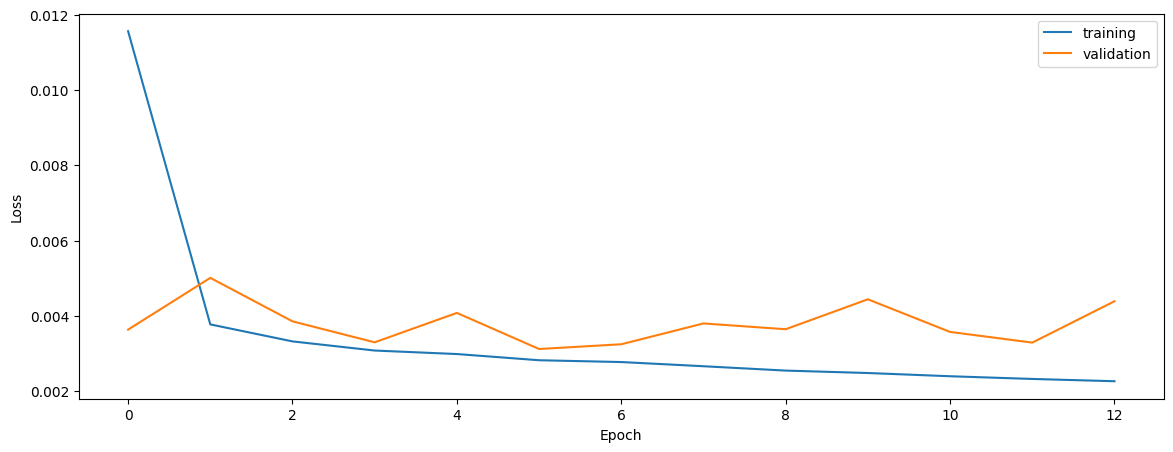

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9737397332872567
0.9670458288180077
0.9673122943553423


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9324336086412646
0.9397489591107893
0.9360191130480678


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9412545454340712
0.9436139217136364
0.9512354689941619


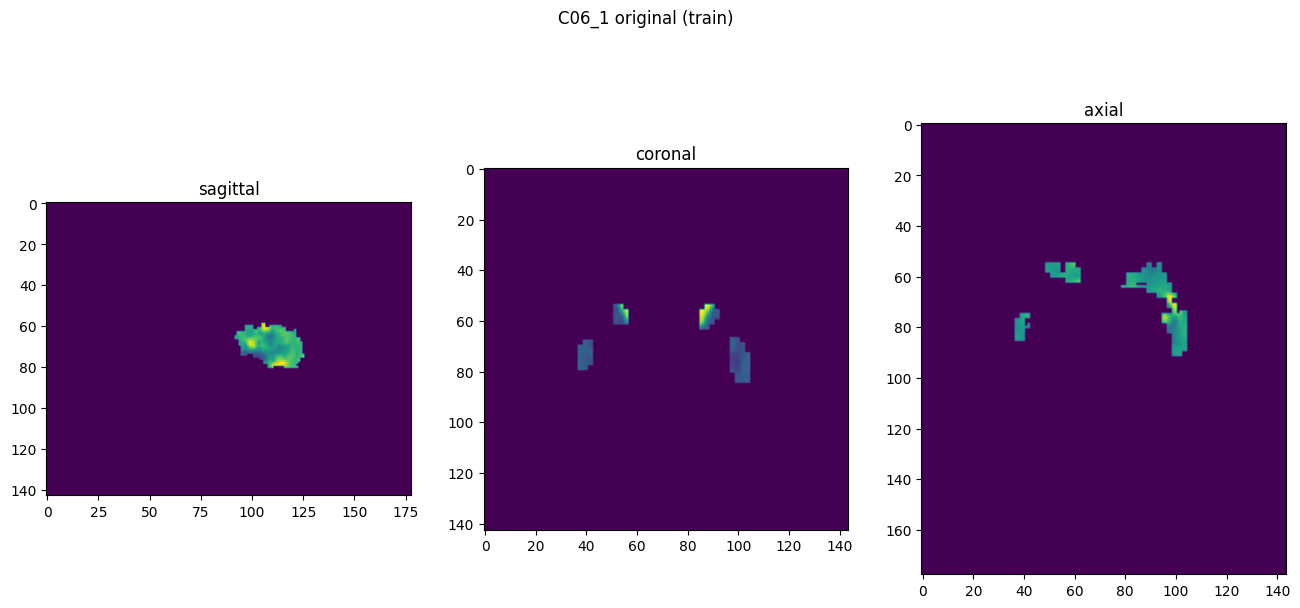

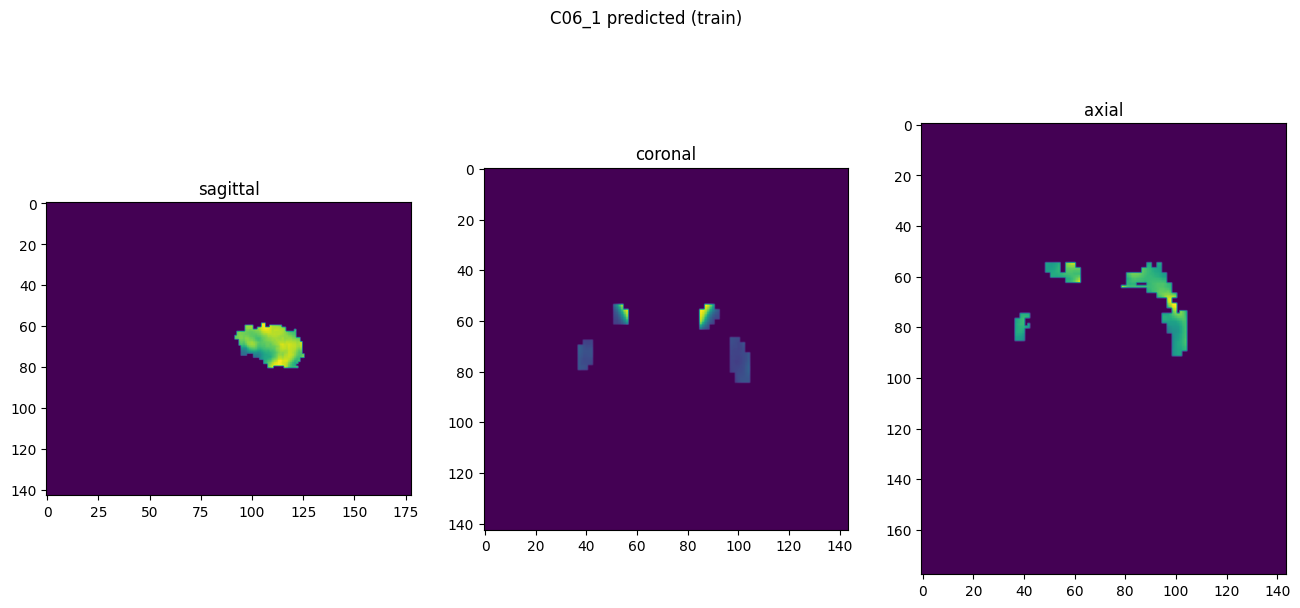

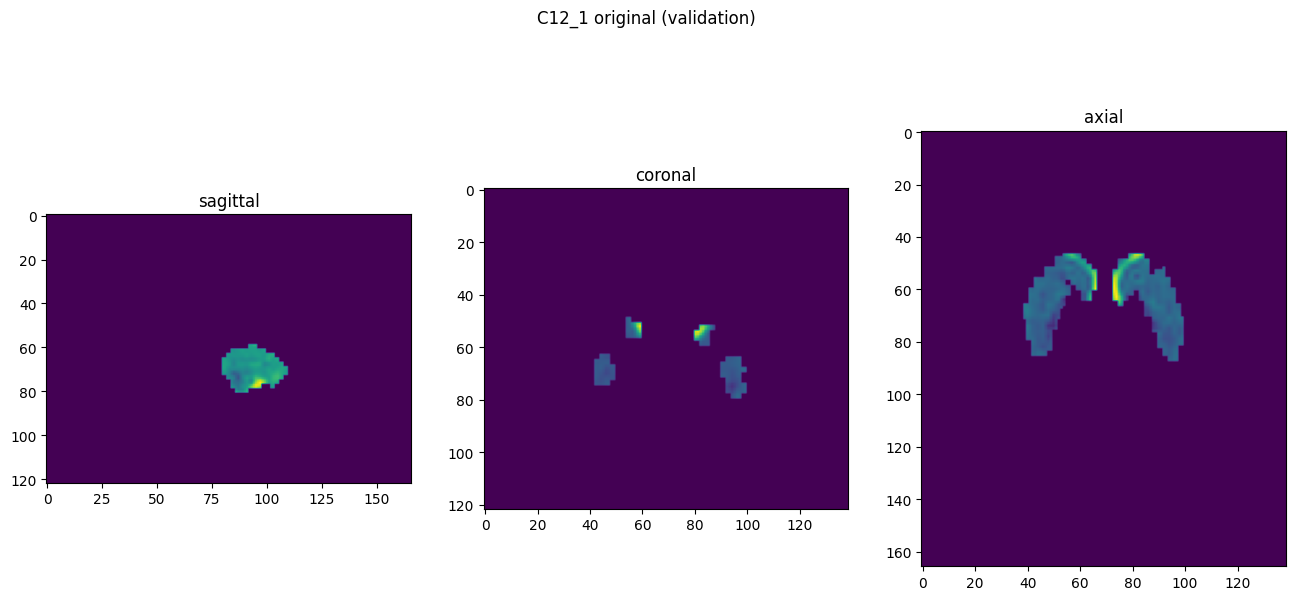

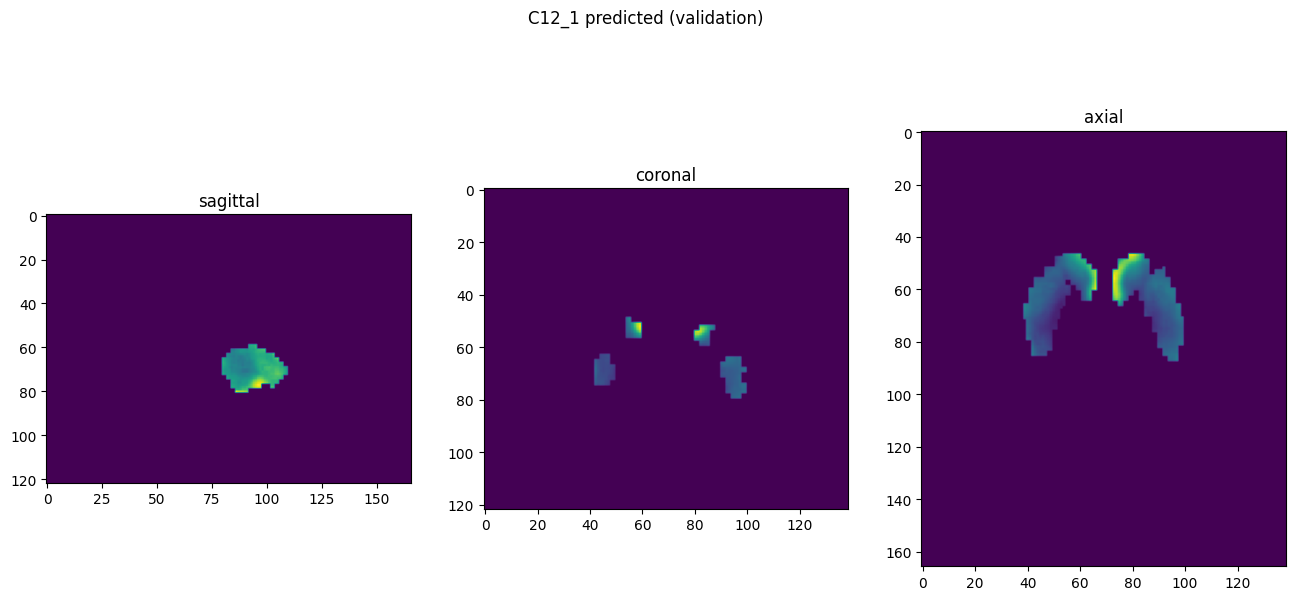

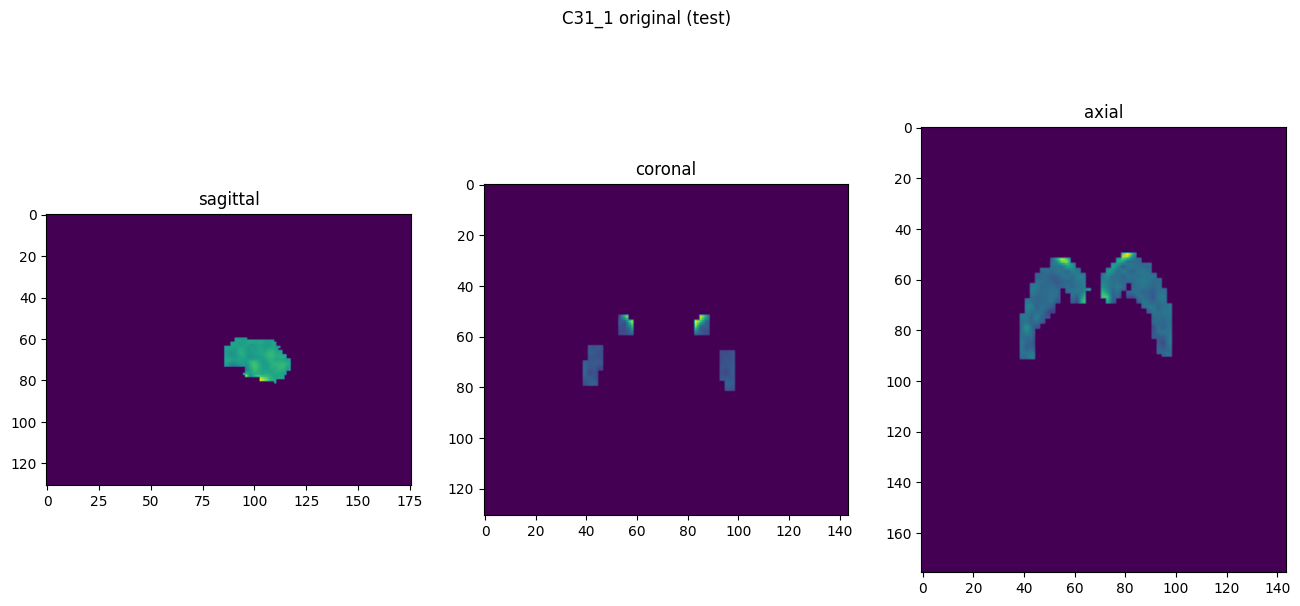

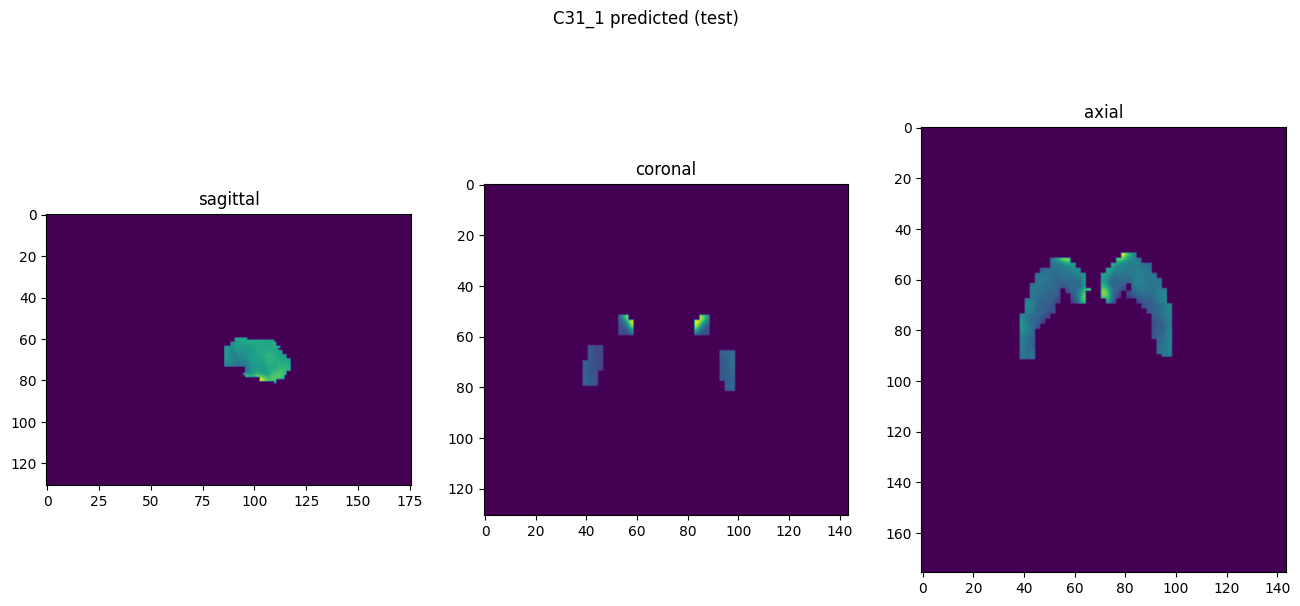

In [10]:
showResults(model, gen, threshold=None, background=False)